# Exploratory Data Analysis

---

This few-shot benchmark tests various meta-learning methods in the context of
biomedical applications. In particular, we are dealing with the [Tabula Muris]()
and [SwissProt]() datasets. One is a cell type classification task based on
single-cell gene expressions and the other is a protein function prediction task
based on protein sequences. The goal of this notebook is to explore basic
statistics about the two datasets, as well as understand how the data loading is
implemented for the episodic training during meta-training.


## Setup

---

First, let's import the relevant modules needed.


In [1]:
# ruff: noqa: E402
# Reload modules automatically
%reload_ext autoreload
%autoreload 2

# Module imports
import sys
import time
from collections import Counter

# External imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

In [2]:
# Add path to load local modules
sys.path.append("..")

# Set styles
sns.set_style("whitegrid")

## Base Classes

---

Both datasets are implemented as subclasses of the `FewShotDataset` class and
use some other generic utility classes. We will explore these here in detail.
They are all defined in the `datasets.dataset` module.


### FewShotDataset

The `FewShotDataset(torch.utils.data.Dataset)` is the base class for all
few-shot datasets. It implements the `__getitem__` and `__len__` methods and has
some utilities for checking the data validty. Furthermore, it is responsible for
loading and extracting the dataset into the `root` directory if specified and
not yet existent. However, as it is a abstract base class, it cannot be
instantiated, e.g. it requires the `_dataset_name` and `_dataset_dir` as class
attributes.


In [3]:
# Demo: FewShotDataset
from datasets.dataset import FewShotDataset  # noqa

try:
    few_shot_dataset = FewShotDataset()
except Exception as e:
    print(f"❌ Fails with error {e}.")

❌ Fails with error FewShotDataset must have attribute _dataset_name..


In [4]:
# Demo FewShotSubDataset
from datasets.dataset import FewShotSubDataset  # noqa

# Create a random dataset with 100 samples, 5 features and 5 classes
samples = torch.rand(100, 5)
targets = torch.randint(0, 5, (100,))  # 5-way
subset_target = 4

# Get all samples that belong to class 4
subset_samples = samples[targets == subset_target]

# Create a few-shot dataset for class 4
few_shot_sub_dataset = FewShotSubDataset(subset_samples, subset_target)

# Sanity checks
assert (
    len(few_shot_sub_dataset) == (targets == subset_target).sum()
), "❌ Length of few-shot dataset is not correct."
assert (
    few_shot_sub_dataset.dim == samples.shape[1]
), "❌ Dimension of few-shot dataset is not correct."

### Episodic Batch Sampler

The `EpisodicBatchSampler` is a utility class that randomly samples `n_way`
classes (out of a total of `n_classes`) for a total of `n_episodes`. It can be
used in episodic training to sample the classes used in each episode.

The sampler is `n_episodes` long and each time samples randomly (without
replacement) from `{0, ..., n_classes-1}` `n_way` times.


In [5]:
# Demo: EpisodicBatchSampler
from datasets.dataset import EpisodicBatchSampler  # noqa

# Demo of EpisodicBatchSampler
n_episodes, n_way, n_classes = 3, 5, 10
episodic_batch_sampler = EpisodicBatchSampler(n_classes, n_way, n_episodes)

print(f"Episodes: {n_episodes}, Ways: {n_way}, Classes: {n_classes}")
for batch_idx, indices in enumerate(episodic_batch_sampler):
    print(f"Episode {batch_idx+1} w/ classes {indices.numpy()}")

Episodes: 3, Ways: 5, Classes: 10
Episode 1 w/ classes [5 6 9 0 8]
Episode 2 w/ classes [5 4 8 6 9]
Episode 3 w/ classes [1 3 7 4 0]


## Tabula Muris

---

**Tabula Muris** is a dataset of single cell transcriptome data (gene
expressions) from mice, containing nearly `100,000` cells from `20` organs and
tissues. The data allow for direct and controlled comparison of gene expression
in cell types shared between tissues, such as immune cells from distinct
anatomical locations. They also allow for a comparison of two distinct technical
approaches:

_More Resources_:

- [Tabular Muris Website](https://tabula-muris.ds.czbiohub.org/)
- [SF Biohub Article](https://www.czbiohub.org/sf/tabula-muris/)


### TMSimpleDataset

The `TMSimpleDataset` is a simple dataset class that is designed for regular
multi-class classification training/ fine-tuning. It loads the entire
(processed) dataset into memory and wraps inside a PyTorch Dataset object.
Supports functionality for retrieving a single sample, a batched data loader and
the dimensionality of the data.

_Note: Upon first call, the `TMSimpleDataset` class will download the data into
the `root` directory._


In [6]:
# Demo: TMSimpleDataset
from datasets.cell.tabula_muris import TMSimpleDataset  # noqa

# Arguments to provide
batch_size = 10
root = "../data"
min_samples = 20
subset = 1.0

kwargs = {
    "batch_size": batch_size,
    "root": root,
    "min_samples": min_samples,
    "subset": subset,
}

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

# Initialise TabulaMuris training dataset
for mode in modes:
    start = time.time()
    data = TMSimpleDataset(**kwargs, mode=mode)
    print(
        f"✅ TabulaMuris {mode} split ({len(data)}) loaded in {time.time() - start:.2f} seconds."
    )

✅ TabulaMuris train split (65812) loaded in 11.33 seconds.
✅ TabulaMuris val split (14962) loaded in 4.89 seconds.
✅ TabulaMuris test split (25065) loaded in 4.64 seconds.


Now, the raw data is downloaded and saved onto disk. Let's view the size of the
raw and processed data.


In [7]:
# This asssumes the data is already downloaded
!du -sh ../data/tabula_muris/*

 84M	../data/tabula_muris/gene_association.mgi
 32M	../data/tabula_muris/go-basic.obo
3.2G	../data/tabula_muris/processed
2.3G	../data/tabula_muris/tabula-muris-comet.h5ad


In [8]:
!du -sh ../data/tabula_muris/processed/*

4.0K	../data/tabula_muris/processed/mapping.pkl
3.2G	../data/tabula_muris/processed/tabula-muris.pkl


Nice, let's take a look at the data and plot some general dataset statistics.


In [9]:
# Load all data splits
train_data = TMSimpleDataset(**kwargs, mode="train")
val_data = TMSimpleDataset(**kwargs, mode="val")
test_data = TMSimpleDataset(**kwargs, mode="test")

In [10]:
# Print number of samples in each split
print(f"ℹ️ Tabula Muris dataset has {len(train_data)} train samples.")
print(f"ℹ️ Tabula Muris dataset has {len(val_data)} train samples.")
print(f"ℹ️ Tabula Muris dataset has {len(test_data)} train samples.\n")

# Print number of classes (cell types) in each split
print(
    f"ℹ️ Tabula Muris train dataset has {len(np.unique(train_data.targets))} unique classes."
)
print(
    f"ℹ️ Tabula Muris val dataset has {len(np.unique(val_data.targets))} unique classes."
)
print(
    f"ℹ️ Tabula Muris tests dataset has {len(np.unique(test_data.targets))} unique classes."
)

ℹ️ Tabula Muris dataset has 65812 train samples.
ℹ️ Tabula Muris dataset has 14962 train samples.
ℹ️ Tabula Muris dataset has 25065 train samples.

ℹ️ Tabula Muris train dataset has 57 unique classes.
ℹ️ Tabula Muris val dataset has 39 unique classes.
ℹ️ Tabula Muris tests dataset has 36 unique classes.


Let's first look at the samples and their features. We can obtain a single
sample using indexing into the data. We will plot the dimensionality of each
sample and hope to see the same number of features for each sample.


In [11]:
# Get sample from each split
train_x, train_y = train_data[0]
val_x, val_y = val_data[0]
test_x, test_y = test_data[0]

# Print sample shapes
print(
    f"ℹ️ Tabula Muris train sample has shape {train_x.shape} and cell type {train_y}."
)
print(
    f"ℹ️ Tabula Muris val sample has shape {val_x.shape} and cell type {val_y}.")
print(
    f"ℹ️ Tabula Muris test sample has shape {test_x.shape} and cell type {test_y}.")

ℹ️ Tabula Muris train sample has shape (2866,) and cell type 2.
ℹ️ Tabula Muris val sample has shape (2866,) and cell type 8.
ℹ️ Tabula Muris test sample has shape (2866,) and cell type 12.


Each sample is a tuple of (sample, target) where sample is a torch.Tensor of
shape (n_genes,) and target is a torch.Tensor of shape (1,) which denotes the
cell type. We can see that the targets are encoded as integers, so we will need
to decode them to get the actual cell type. Let's look at the feature
distributions of some genes.


The `data` attribute of the dataset class is a `AnnData` object which contains
annotations about the samples, here information about the cells (e.g. cell type,
tissue, etc.), as well as the genes (e.g. gene name, mean expression, etc.). We
can access the annotations using the `obs` and `var` attributes of the `AnnData`
object. For now, let's convert he information into a `pd.DataFrame` with the
cell id as index and the gene names as columns.


In [12]:
df_train_data = pd.DataFrame(
    train_data.samples,
    index=train_data.data.obs.index,
    columns=train_data.data.var.index,
)

df_train_data.head(5)

index,0610010O12Rik,0610011F06Rik,0610040J01Rik,1100001G20Rik,1110002N22Rik,1110012J17Rik,1110018G07Rik,1110032A04Rik,1110037F02Rik,1190002H23Rik,...,Zfr2,Zfyve28,Zg16,Zic2,Zkscan5,Zmiz1,Zranb1,Zscan20,Zufsp,Zxdb
index,,,,,,,,,,,,,,,,,,,,,
O12_B002907_S72_L003.mus-1-0-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,0.599566,1.748819,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,1.129154,4.707497,-0.075302,-0.290914,-0.113769
I13_B001357_B009344_S205_L004.mm10-plus-2-0,2.040215,2.322792,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,1.023308,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.295462,-0.331498,-0.075302,2.988340,-0.113769
D10.B000633.3_56_F.1.1-1-1,-0.455878,1.590420,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.489169,-0.331498,-0.075302,-0.290914,-0.113769
E10.D045067.3_38_F.1.1-1-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.489169,1.470401,-0.075302,-0.290914,-0.113769
A5_B000331_S5_L004.mus-6-0-1,-0.455878,1.428808,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,2.813931,-0.422841,...,1.985093,-0.083278,-0.134978,-0.103771,0.448235,0.456905,-0.273370,-0.075302,-0.290914,-0.113769


Let's compute some numeric summaries of the data. We use `info()` to obtain
information about the data types and missing values and `describe()` to obtain
some basic statistics about the data. We will limit the output to the first 10
genes.


In [13]:
# Show numeric summaries for first 10 cells (samples)
num_genes = 10
df_train_data.iloc[:, :num_genes].info()

<class 'pandas.core.frame.DataFrame'>
Index: 65812 entries, O12_B002907_S72_L003.mus-1-0-1 to G20.MAA000801.3_11_M.1.1-1-1
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0610010O12Rik  65812 non-null  float32
 1   0610011F06Rik  65812 non-null  float32
 2   0610040J01Rik  65812 non-null  float32
 3   1100001G20Rik  65812 non-null  float32
 4   1110002N22Rik  65812 non-null  float32
 5   1110012J17Rik  65812 non-null  float32
 6   1110018G07Rik  65812 non-null  float32
 7   1110032A04Rik  65812 non-null  float32
 8   1110037F02Rik  65812 non-null  float32
 9   1190002H23Rik  65812 non-null  float32
dtypes: float32(10)
memory usage: 3.0+ MB


All gene expressions (features) are numeric, continuous and non-null.


In [14]:
# Show numeric summaries for first 10 genes (features)
num_genes = 10
df_train_data.iloc[:, :num_genes].describe()

index,0610010O12Rik,0610011F06Rik,0610040J01Rik,1100001G20Rik,1110002N22Rik,1110012J17Rik,1110018G07Rik,1110032A04Rik,1110037F02Rik,1190002H23Rik
count,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000,65812.000000
mean,-0.075218,-0.114087,0.037429,-0.087274,-0.025811,-0.036437,-0.015501,-0.024247,-0.019214,0.047289
std,0.888354,0.911810,1.127549,0.601624,0.988741,0.749347,0.972404,0.984504,0.982419,1.090133
min,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
25%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
50%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
75%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
max,10.000000,10.000000,8.453063,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.532121


We verify that there are no missing values. Furthermore, we observe an
interesting pattern in the data. The mean is always in the range `~0` and the
standard deviation is around `~1`. The vast majority (at least 75%) is at the
minimum value which is a small negative value. This suggests a strong
heavy-tailed distribution. The maximum value is a lot larger than the mean and
standard deviation, suggesting strong outliers. Interestingly, the maximum value
is never larger than 10 - this might be due to some pre-processing (e.g. cutting
the data at 10).

Let's visualise the distributions of the first 10 genes.


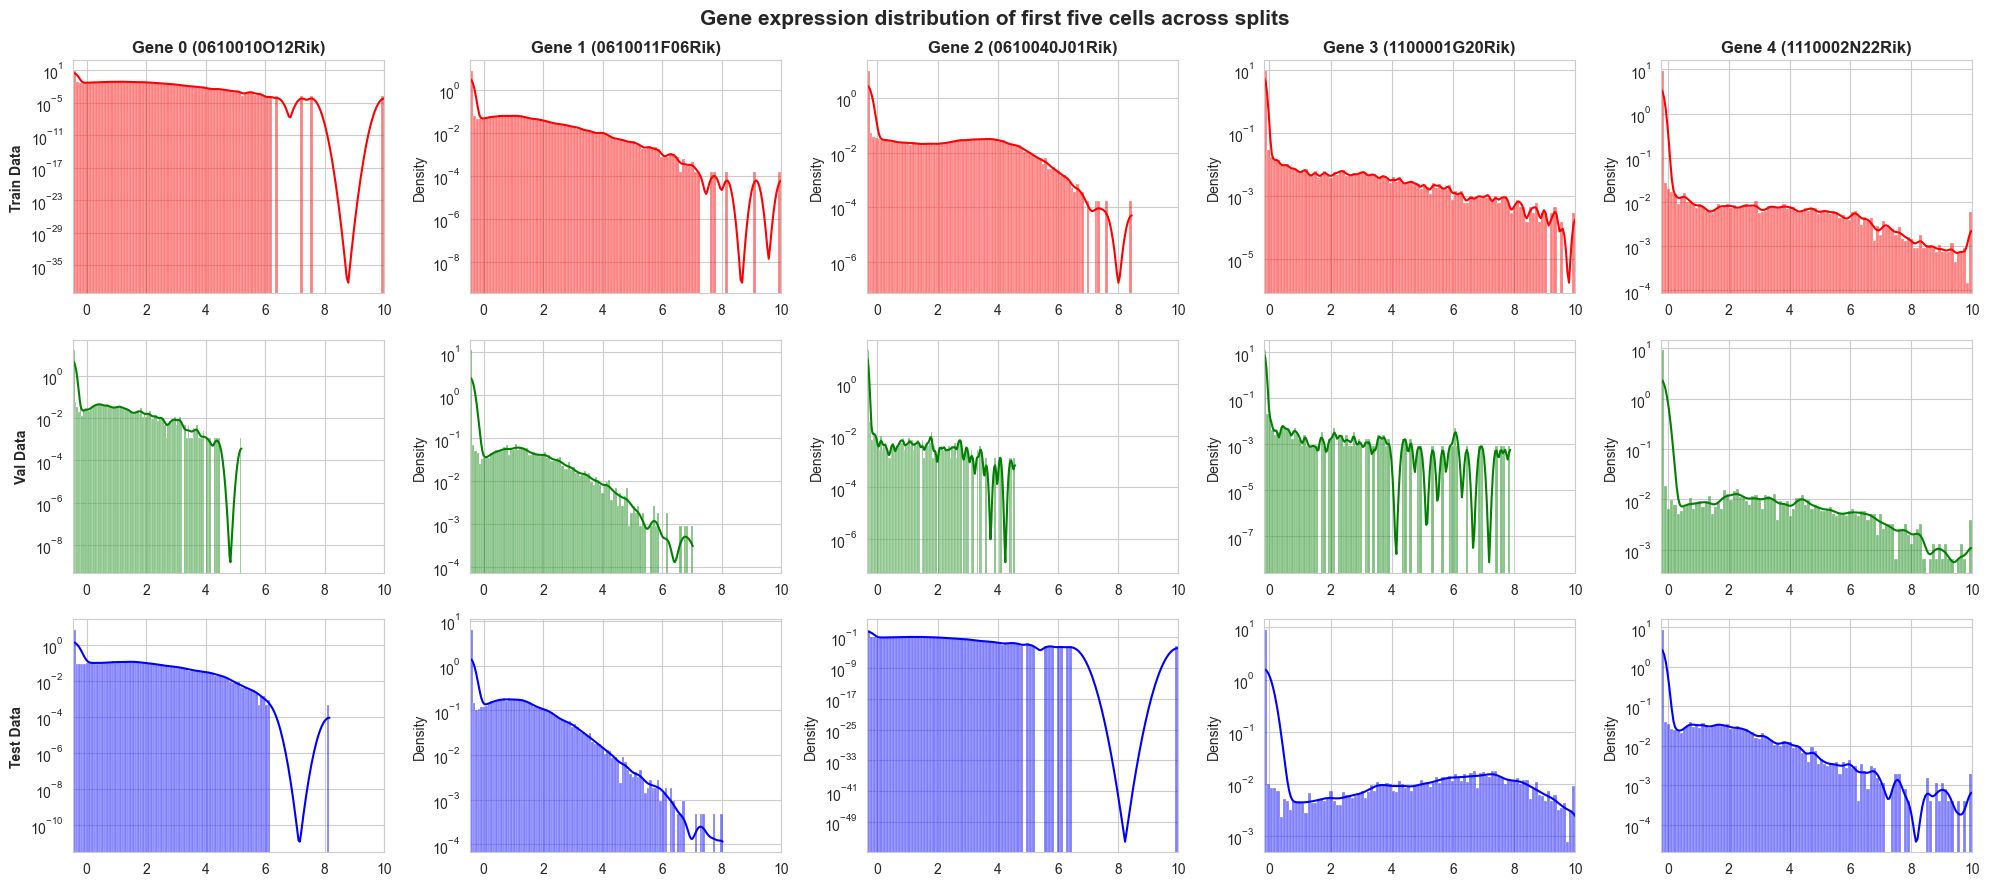

In [15]:
num_genes = 5  # Visualise the first five genes
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 9))

for j in range(num_genes):
    min_val, max_val = np.inf, -np.inf
    for i, data in enumerate([train_data, val_data, test_data]):
        # Get data of first five cells in split
        x = data.samples[:, :num_genes]

        xmin_val, xmax_val = x[:, j].min(), x[:, j].max()
        if xmin_val < min_val:
            min_val = xmin_val
        if xmax_val > max_val:
            max_val = xmax_val

        # Plot the first five genes
        sns.histplot(
            x=x[:, j],
            ax=axs[i, j],
            kde=True,
            bins=100,
            stat="density",
            color=["red", "green", "blue"][i],
        )

        axs[i, 0].set_ylabel(f"{data.mode.capitalize()} Data", fontweight="bold")

    # Set x-axis limits
    for i in range(3):
        axs[i, j].set_xlim(min_val, max_val)
        axs[i, j].set_yscale("log")

    axs[0, j].set_title(f"Gene {j} ({data.data.var.iloc[j].name})", fontweight="bold")


fig.suptitle(
    "Gene expression distribution of first five cells across splits",
    fontsize=15,
    fontweight="bold",
)
fig.tight_layout()

We visualise the gene expression distribution of the first five (out of 2866)
genes across the three splits using hisotgrams with overlayed kernel density
estimates and log the y-axis to better understand the tail of the distribution.
We can see that the gene expression distribution generally follows a
heavy-tailed distribution, with a few genes having very high expression values.
We can also see that the distribution are potentially different across the three
splits, which is expected as the splits represent cells from different tissues
and the cells were selected based on general variance in gene expression. One
would hope that similar differences are also present when plotting by cell type,
as such differences would be useful for classification.

> Most of these findings align with the pre-processing steps described in
> `data.utils.py` in the `preprocess` method. After filtering out samples and
> features (e.g. too little expressions for a cell, too little variance of a
> gene across cells), the data is a) log-transformed, b) zero-centered (and cut
> off at 10) and c) zero-imputed. Thus, the original data must have been even
> more heavy-tailed and sparse but now we observe zero-centered distribution
> with no missing values and a heavy-tail data is cut at 10.


Let's now understand the class distribution of the data. In this task, the label
is the cell type (`cell_ontology_class_reannotated`). To make this a suitable
transfer/ few-shot learning task the samples from the different splits originate
from different tissues (group of similar cvelles that work together to perform a
specific function). We can recover the original tissues, cell types and integer
encoded labels.


Text(0.5, 0.98, 'Tissue distribution')

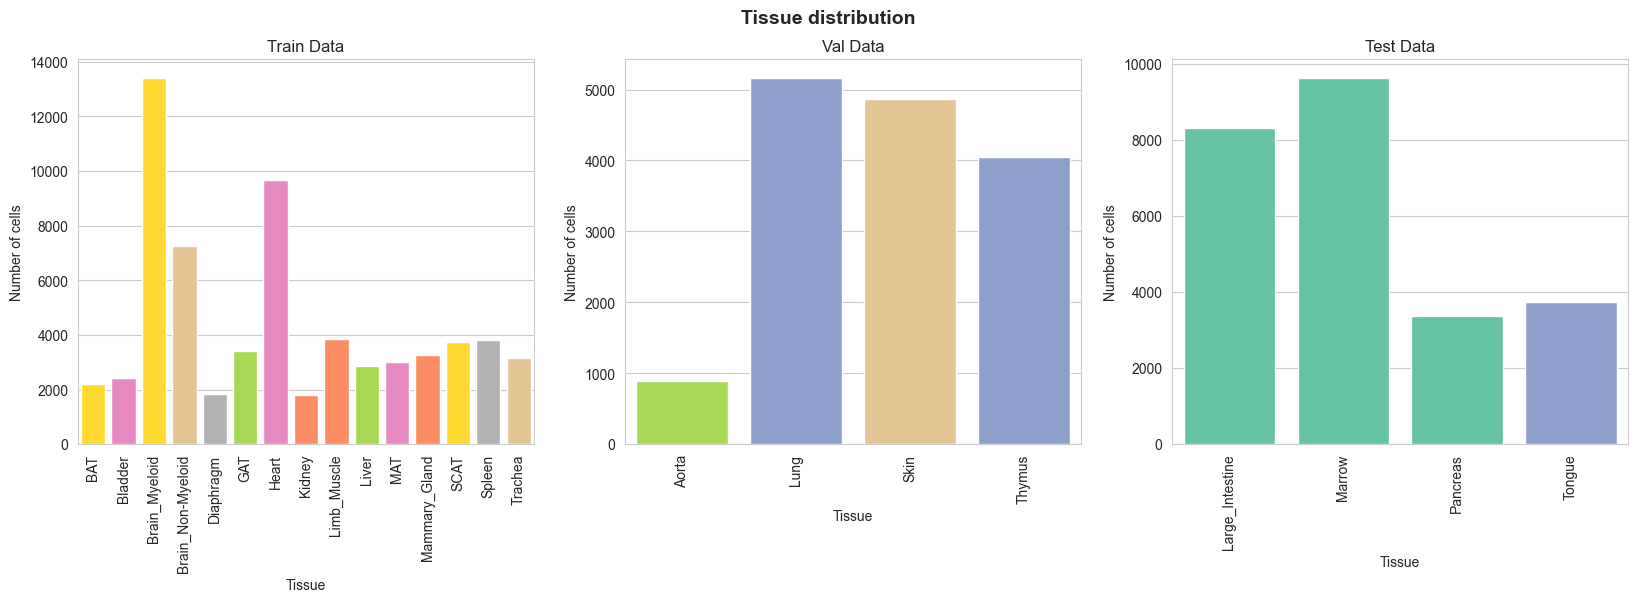

In [16]:
# Plot tissue distribution
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

all_tissues = list(
    set(train_data.data.obs.tissue.unique())
    | set(val_data.data.obs.tissue.unique())
    | set(test_data.data.obs.tissue.unique())
)
all_colors = sns.color_palette("Set2", n_colors=len(all_tissues))
tissue2idx = {tissue: i for i, tissue in enumerate(all_tissues)}
for ax, data in zip(axs, [train_data, val_data, test_data]):
    tissues = data.data.obs.tissue.value_counts()
    ax = sns.barplot(x=tissues.index, y=tissues.values, ax=ax)

    # Set colors
    colors = [all_colors[tissue2idx[tissue]] for tissue in tissues.index]
    for bar, color in zip(ax.containers[0], colors):
        bar.set_facecolor(color)

    ax.set(
        xlabel="Tissue",
        ylabel="Number of cells",
        title=f"{data.mode.capitalize()} Data",
    )
    # Rotate x-axis labels
    ax.tick_params(axis="x", rotation=90)

fig.suptitle("Tissue distribution", fontsize=14, fontweight="bold")

This aligns with the pre-processing that we set in the dataset class. There are
15 tissues in training and four in validation and test. Crucially, these are
disjoint, e.g. we will never have a cell from type `Lung` in our training. Let's
next look at the target distribution across the splits, which are the cell
types.

There are three different ways to obtain the label of a sample from the dataset:

1. In the `obs.cell_ontology_class_reannotated` column of the `AnnData` object
   (`data` attribute of the dataset class). This will be the string
   representation of the cell type.

2. In the `obs.label` column of the `AnnData` object (`data` attribute of the
   dataset class). This will be the integer representation of the cell type.

3. In the `target` attribute of the dataset class. This will be the integer
   representation that is specific to the split (e.g. does not match up with the
   integer representation of the `AnnData` object). It creates a new mapping {0,
   ..., n_classes-1} for all cell types that are present in the tissues of the
   split. Thus, the integer representation of the cell type cannot be compared
   across splits.


Let's showcase this by finding a cell type training set and validation set and
show that they share the string representation and global integer code, but not
the cell specific integer code.


In [17]:
label = "endothelial cell"

# Obtaining label of sample from train split
train_mask = train_data.data.obs.cell_ontology_class_reannotated == label
val_mask = val_data.data.obs.cell_ontology_class_reannotated == label

print(f"Label: {label}")
print(
    f"Global train encoding: {train_data.data[train_mask].obs.label.values[0]}")
print(f"Global val encoding: {val_data.data[val_mask].obs.label.values[0]}")

print(f"Split train encoding: {train_data[train_mask][1][0]}")
print(f"Split train encoding: {val_data[val_mask][1][0]}")

Label: endothelial cell
Global train encoding: 36
Global val encoding: 36
Split train encoding: 16
Split train encoding: 15


As we can see `endothelial cell` is encoded as `36` in the global encoding (used
in the `label` attribute and which is saved in `trg2idx` and `idx2trg` in the
dataset class. However, the encoding per split level may vary. Let's check the
overlap between the cell types between the splits using the original string
representation.


In [18]:
train_classes = set(
    train_data.data.obs.cell_ontology_class_reannotated.unique())
val_classes = set(val_data.data.obs.cell_ontology_class_reannotated.unique())
test_classes = set(test_data.data.obs.cell_ontology_class_reannotated.unique())

print(
    f"ℹ️ Total unique cell types: {len(train_classes | val_classes | test_classes)}\n"
)

print(f"ℹ️ Unique cell types in train: {len(train_classes)}")
print(f"ℹ️ Unique cell types in val: {len(val_classes)}")
print(f"ℹ️ Unique cell types in test: {len(test_classes)}\n")

print(
    f"ℹ️ Unique cell types shared in all: {len(train_classes & val_classes & test_classes)} {train_classes & val_classes & test_classes}"
)

print(
    f"ℹ️ Unique cell types shared in train and val: {len(train_classes & val_classes)} {train_classes & val_classes}"
)
print(
    f"ℹ️ Unique cell types shared in train and test: {len(train_classes & test_classes)} {train_classes & test_classes}"
)
print(
    f"ℹ️ Unique cell types shared in val and test: {len(val_classes & test_classes)} {val_classes & test_classes}"
)

ℹ️ Total unique cell types: 116

ℹ️ Unique cell types in train: 57
ℹ️ Unique cell types in val: 39
ℹ️ Unique cell types in test: 36

ℹ️ Unique cell types shared in all: 2 {'NK cell', 'endothelial cell'}
ℹ️ Unique cell types shared in train and val: 10 {'neutrophil', 'CD4-positive, alpha-beta T cell', 'macrophage', 'B cell', 'endothelial cell', 'CD8-positive, alpha-beta T cell', 'NK cell', 'fibroblast', 'T cell', 'fibroblast of cardiac tissue'}
ℹ️ Unique cell types shared in train and test: 4 {'keratinocyte', 'NK cell', 'granulocyte', 'endothelial cell'}
ℹ️ Unique cell types shared in val and test: 4 {'leukocyte', 'NK cell', 'basal cell of epidermis', 'endothelial cell'}


There are more unique cell types in the train split as there are more unique
tissues in the train split. It seems that cell types are pretty closely linked
(specific) to tissues, because there is little overlap between the cell types in
the different splits. Most cell types seem to only occur in a specific tissue,
and few cell types have general functions that are needed in multiple tissues.
We see that there are only 2 cell types that are present all splits, 10 that are
shared between train and val and 4 that are shared between train and test and
train and val.

This means that the task is not trivial. Learning a mapping from gene expression
to cell type purely on the training set doesn't mean good performance on the
validation or test split as these contain cell types that are not present in the
training set.


Let's verify the relationship between tissues and cell types by plotting the
cooccurrence matrix.


In [19]:
# Pivot to get cooccurence matrix of tissue and cell type
def tissue_cell_type_cooccurrence(data, ax):
    tmp = data.data.obs.pivot_table(
        index="tissue",
        columns="cell_ontology_class_reannotated",
        values="label",
        aggfunc="count",
        fill_value=0,
    )

    # Row normalise
    tmp = tmp.div(tmp.sum(axis=1), axis=0)

    sns.heatmap(tmp, ax=ax)
    ax.set(
        title=f"{data.mode.capitalize()} tissue and cell type cooccurrence matrix",
        xlabel="Cell type",
        ylabel="Tissue",
    )

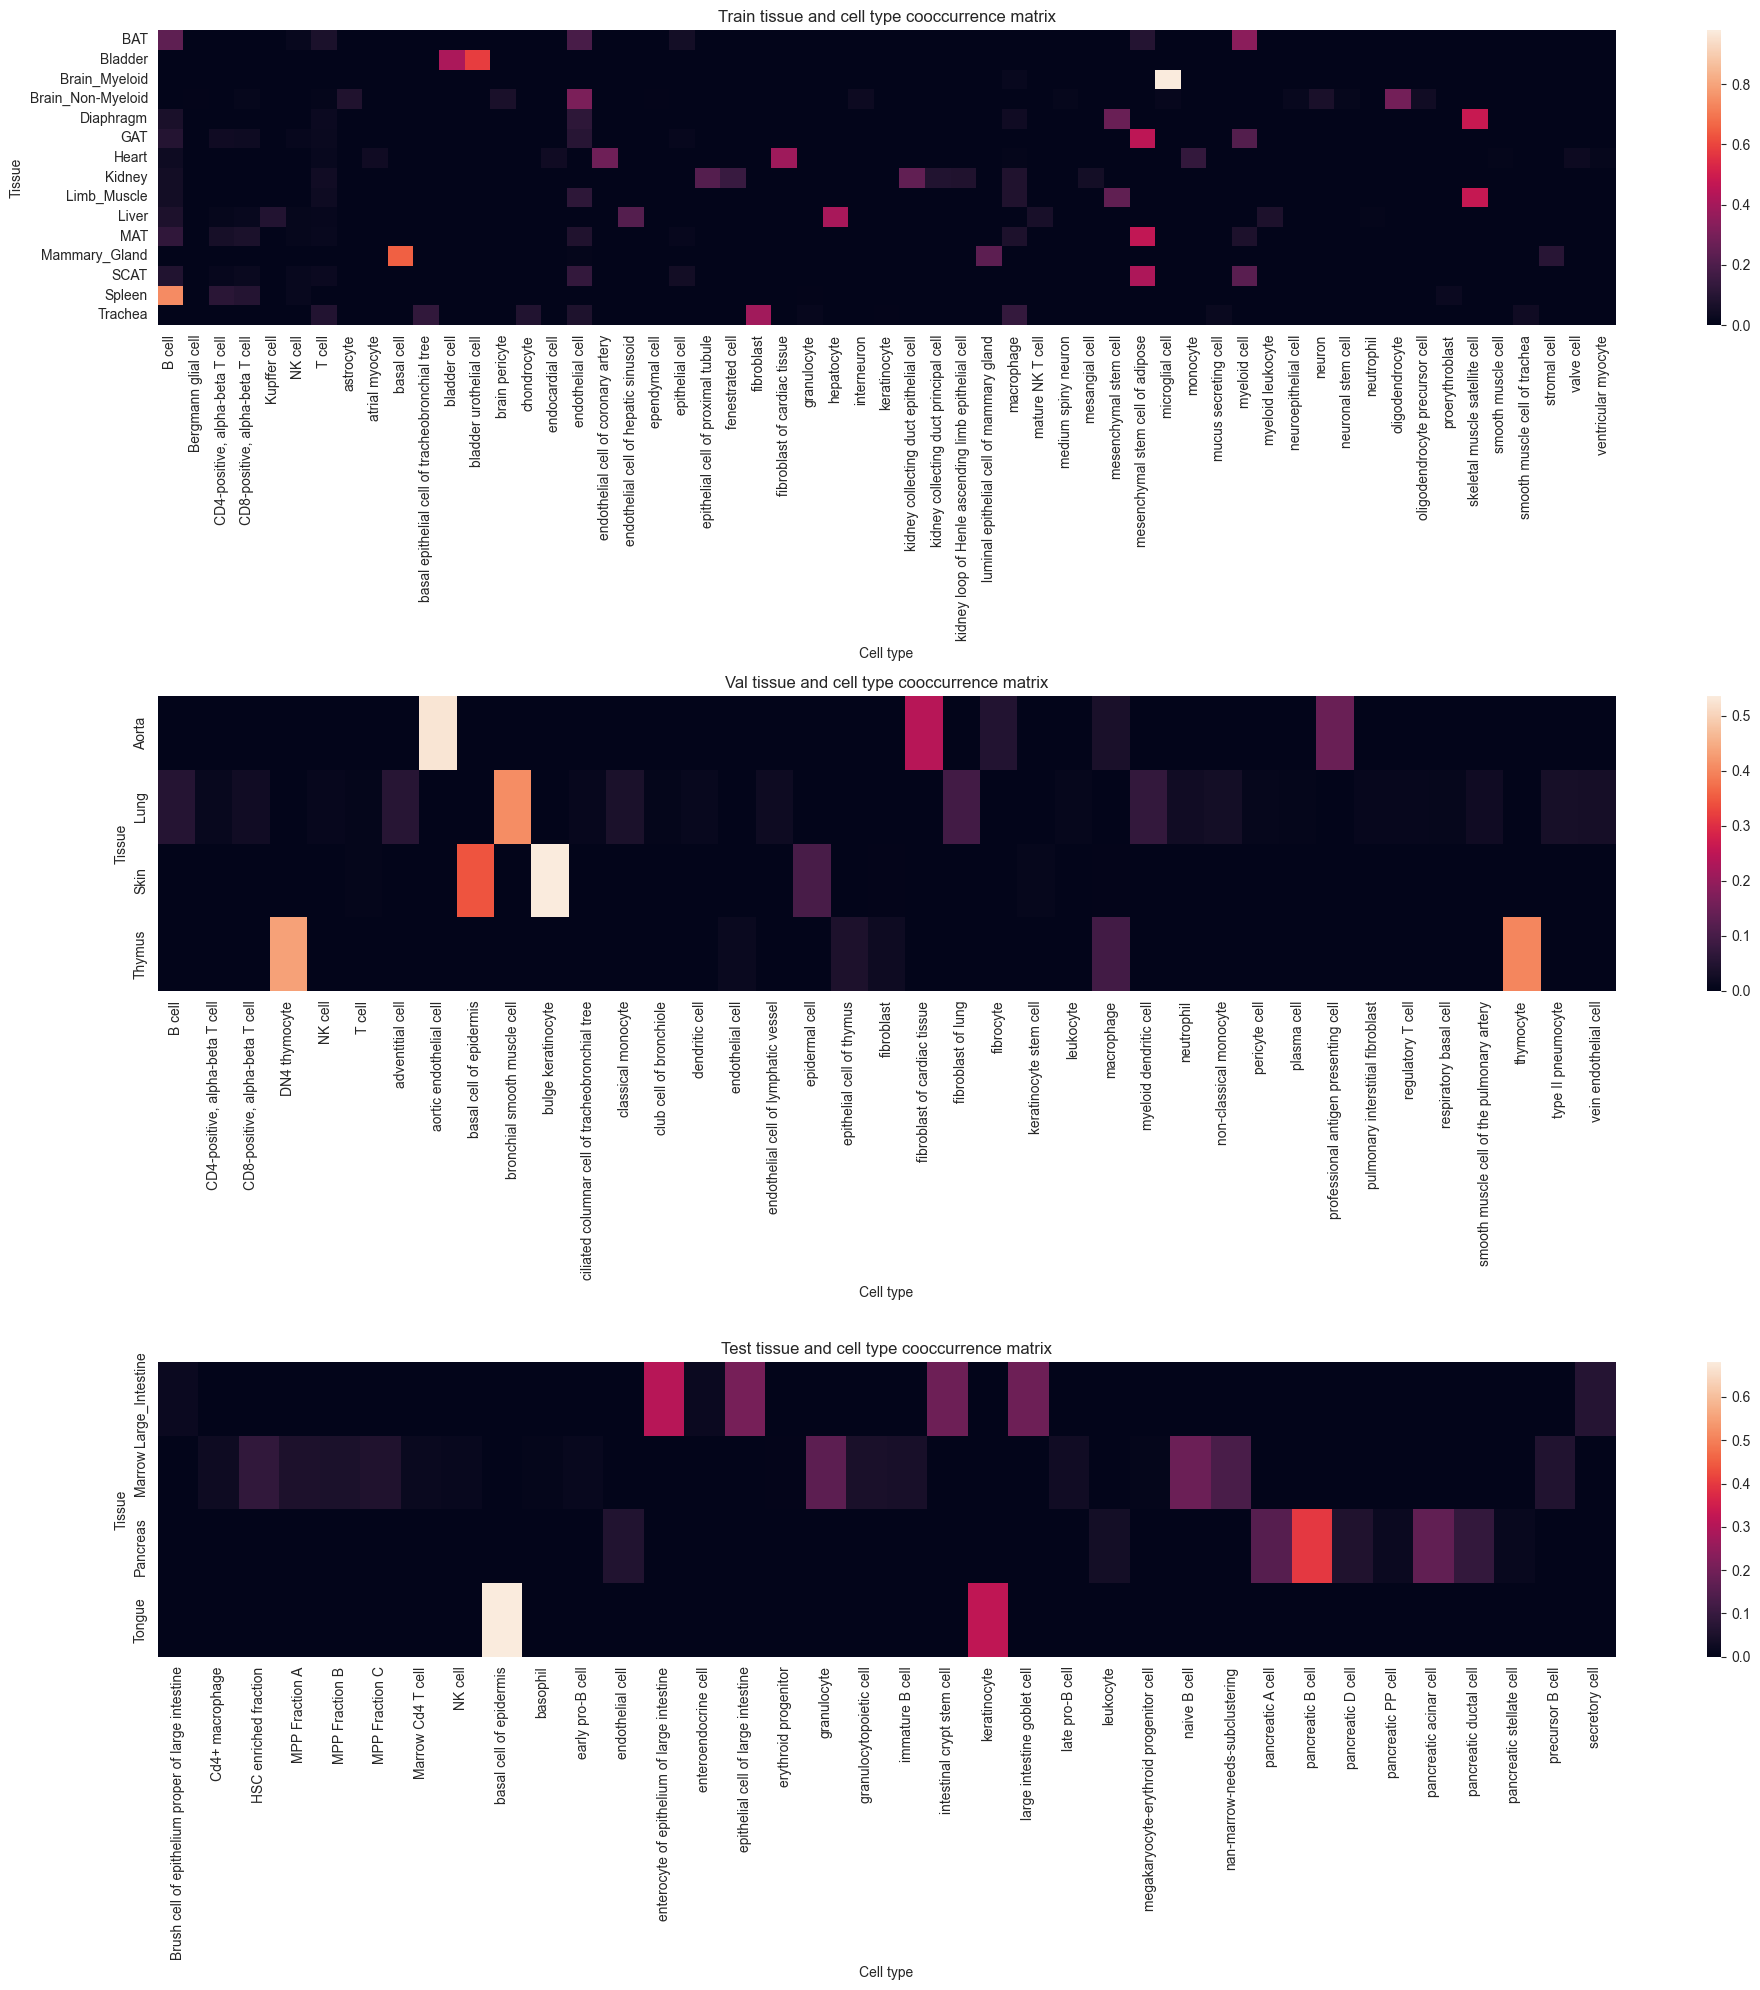

In [20]:
# Plot cooccurrence matrix of tissue and cell type
fig, ax = plt.subplots(nrows=3, figsize=(20, 20))
tissue_cell_type_cooccurrence(train_data, ax[0])
tissue_cell_type_cooccurrence(val_data, ax[1])
tissue_cell_type_cooccurrence(test_data, ax[2])

fig.tight_layout()

As suspected, cell types are often very tightly coupled with tissue types. Thus,
splitting on tissue types for a few-shot learning task means to a large extent
splitting on cell types as well. For good measure, let's also plot the target
distribution of the cell types in the train, val and test split.


Text(0.5, 0.98, 'Cell type distribution')

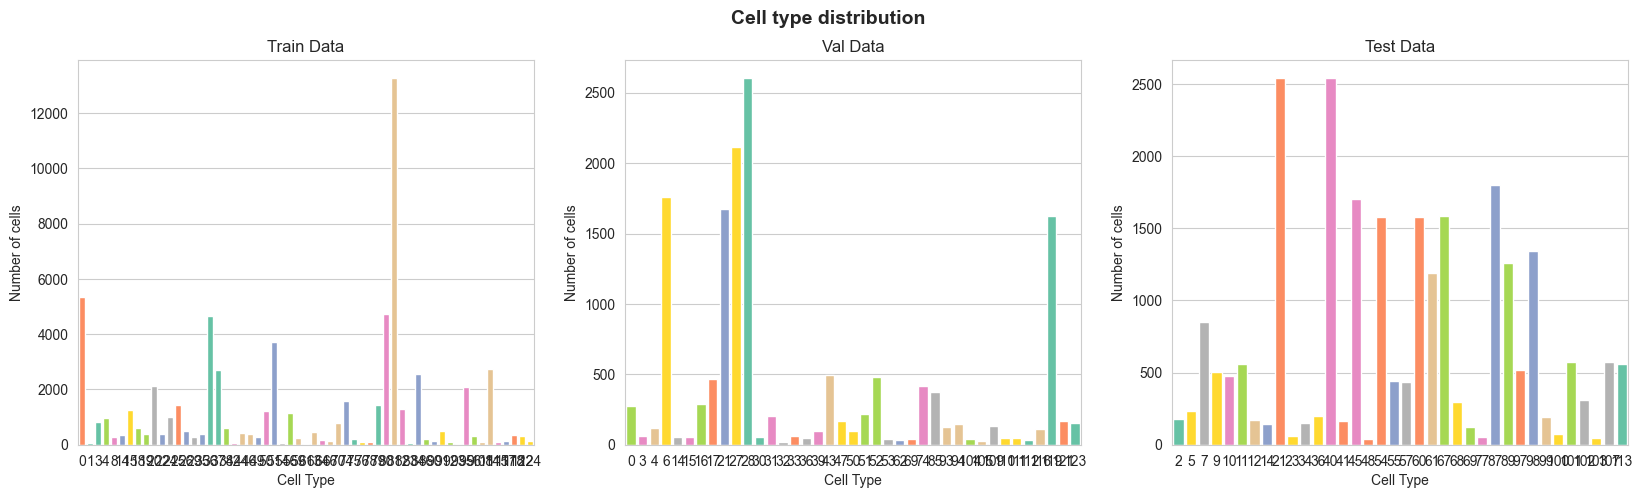

In [21]:
# Visualise the class distributions
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

all_labels = list(
    set(train_data.data.obs.label.unique())
    | set(val_data.data.obs.label.unique())
    | set(test_data.data.obs.label.unique())
)
all_colors = sns.color_palette("Set2", n_colors=max(all_labels) + 1)
for ax, data in zip(axs, [train_data, val_data, test_data]):
    labels_enc = data.data.obs.label.value_counts()
    sns.barplot(x=labels_enc.index, y=labels_enc.values, ax=ax)

    # Set colors
    colors = [all_colors[label] for label in labels_enc.index]
    for bar, color in zip(ax.containers[0], colors):
        bar.set_facecolor(color)

    ax.set(
        xlabel="Cell Type",
        ylabel="Number of cells",
        title=f"{data.mode.capitalize()} Data",
    )

fig.suptitle("Cell type distribution", fontsize=14, fontweight="bold")

### TMSetDataset

The `TMSetDataset` is designed for few-shot learning. Most configurations are
the same as for the `TMSimpleDataset`, but crucially the dataset class will
return an episodic batch sampler based on the `n_way`, `n_support`, `n_query`
and parameters.


In [22]:
# Demo: TMSetDataset
from datasets.cell.tabula_muris import TMSetDataset  # noqa

# Arguments to provide
root = "../data"
n_way = 5
n_support = 3
n_query = 3
subset = 1.0

kwargs = {
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "root": root,
    "subset": subset,
}

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

for mode in modes:
    start = time.time()
    TMSetDataset(**kwargs, mode=mode)

    print(
        f"✅ TMSetDataset {mode} split loaded in {time.time() - start:.2f} seconds.")

65846 5 3 4389
✅ TMSetDataset train split loaded in 17.11 seconds.
15023 5 3 1001
✅ TMSetDataset val split loaded in 2.81 seconds.
25083 5 3 1672
✅ TMSetDataset test split loaded in 7.43 seconds.


In a few-shot learning dataset, a single "sample" is defined not as the feature
vector, target tuple of the gene expression levels and the target tissue but as
a set of support and query samples within a class. Thus, the `__getitem__`
method returns a tuple of the support and query samples and targets for the
`i`-th class. Thus, the returned tensor dimension will be
`(n_support + n_query, n_features)` for the samples and
`(n_support + n_query, )` for the targets.


In [23]:
# Load Dataset
data = TMSetDataset(**kwargs, mode="train")

65846 5 3 4389


In [24]:
# Get sample by indexing
tr_smp, tr_trg = data[0]

# Support samples and target
sup_tr_smp, sup_tr_trg = tr_smp[:n_support], tr_trg[:n_support]

# Query samples and target
que_tr_smp, que_tr_trg = tr_smp[n_support:], tr_trg[n_support:]

print(f"Training samples shape: {tr_smp.shape} and target {tr_trg}")
print(f"Support samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")
print(f"Query samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")

Training samples shape: torch.Size([6, 2866]) and target tensor([0, 0, 0, 0, 0, 0], dtype=torch.int32)
Support samples shape: torch.Size([3, 2866]) and target tensor([0, 0, 0], dtype=torch.int32)
Query samples shape: torch.Size([3, 2866]) and target tensor([0, 0, 0], dtype=torch.int32)


Next, the data loader class combines the support-query sampler per class (as
defined above) and the `EpisodicBatchSampler` to create a data loader that
returns batches of episodes where each time we get `n_way` classes with
`n_support` support samples and `n_query` query samples per class. First, the
episodic batch sample samples the `n_way` random class indices and then the
support-query sampler samples the support and query samples for each class.
Thus, the final tensor shapes will be `(n_way, n_query + n_support, n_features)`
for the samples and `(n_way, n_query + n_support, )` for the targets.


In [25]:
# Get data loader
train_loader = data.get_data_loader(num_workers=0, pin_memory=False)

# Get batch
tr_smps, tr_trgs = next(iter(train_loader))

print(f"Training batch shape: {tr_smps.shape} and target {tr_trgs.shape}")
print(f"Targets:\n{tr_trgs}")

Training batch shape: torch.Size([5, 6, 2866]) and target torch.Size([5, 6])
Targets:
tensor([[14, 14, 14, 14, 14, 14],
        [40, 40, 40, 40, 40, 40],
        [ 7,  7,  7,  7,  7,  7],
        [34, 34, 34, 34, 34, 34],
        [21, 21, 21, 21, 21, 21]], dtype=torch.int32)


**NB 1:** Shuffling in meta-learning tasks is not necessary because the episodic
batch sampler and the sub-class sampler are already random.


## SwissProt

---

SWISS-PROT is an annotated protein sequence database, which was created at the
Department of Medical Biochemistry of the University of Geneva (first started
1987). In SWISS-PROT two classes of data can be distinguished: the core data and
the annotation. For each sequence entry the core data consists of the sequence
data; the citation information (bibliographical references) and the taxonomic
data (description of the biological source of the protein), while the annotation
consists of the description of the following items:

- Function(s) of the protein
- Post-translational modification(s). For example carbohydrates,
  phosphorylation, acetylation, GPI-anchor, etc.
- Domains and sites. For example calcium binding regions, ATP-binding sites,
  zinc fingers, homeoboxes, SH2 and SH3 domains, etc.
- Secondary structure. For example alpha helix, beta sheet, etc.
- Quaternary structure. For example homodimer, heterotrimer, etc.
- Similarities to other proteins
- Disease(s) associated with deficiencie(s) in the protein
- Sequence conflicts, variants, etc.

Within this project we will focus on the function annotation of proteins, thus
given the protein sequence (string of amino acids) we want to predict the
function of the protein.

_More Resources_:

- [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC102476/)


### SPSimpleDataset

The `SPSimpleDataset` is a simple dataset class that is designed for regular
multi-class classification training/ fine-tuning. It loads the entire
(processed) dataset into memory and wraps inside a PyTorch Dataset object.
Supports functionality for retrieving a single sample, a batched data loader and
the dimensionality of the data.


In [26]:
# The data has to be manually downloaded to this folder
!du -sh ../data/swissprot/*

111M	../data/swissprot/embeds
 47M	../data/swissprot/filtered_goa_uniprot_all_noiea.gaf
 30M	../data/swissprot/go-basic.obo
 74M	../data/swissprot/processed
8.2M	../data/swissprot/sprot_ancestors.txt
271M	../data/swissprot/uniprot_sprot.fasta


In [27]:
# Demo: TMSetDataset
from datasets.prot.swissprot import SPSimpleDataset  # noqa

# Arguments to provide
root = "../data"
batch_size = 10
min_samples = 6

kwargs = {
    "root": root,
    "batch_size": batch_size,
    "min_samples": min_samples,
}

# Show loading time for each split
modes = ["train", "val", "test"]
for mode in modes:
    start = time.time()
    data = SPSimpleDataset(**kwargs, mode=mode)

    print(
        f"✅ SwissProt {mode} split ({len(data)} samples) loaded in {time.time() - start:.2f} seconds."
    )

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SwissProt train split (11386 samples) loaded in 7.29 seconds.
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SwissProt val split (1213 samples) loaded in 2.59 seconds.
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SwissProt test split (591 samples) loaded in 2.26 seconds.


In [28]:
# This asssumes the data is downloaded manually
!du -sh ../data/swissprot/processed*

 74M	../data/swissprot/processed


Nice, we can load the data fast and easy. The class also supports subsetting
which is useful for debugging the training. However, because we are still
loading all the data into memory before subsetting, we do not get any speed up
(_NB: We could decide to save and load splitted data to disk, but this is not
implemented yet_).

**NB:** The SwissProt dataset as-is is relatively small and can be loaded into
memory without many problems. In this case, subsetting the data decreases the
number of classes that are included according to our specification of the
minimum number of classes and is therefore generally not advised.


Let's load the full training split again and do some exploratory data analysis.


In [29]:
# Demo: SPSimpleDataset
data = SPSimpleDataset(**kwargs, mode="train")

# Get some basic statistics
num_samples = len(data)
dim = data.dim
classes = np.unique([smp.annot for smp in data.samples])
unique_classes = len(classes)

print(f"ℹ️ SwissProt train split has {len(data)} samples")
print(f"ℹ️ Each sample is an encoded protein sequence of length {dim}")
print(f"ℹ️ SwissProt train split has {unique_classes} classes.")

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
ℹ️ SwissProt train split has 11386 samples
ℹ️ Each sample is an encoded protein sequence of length 1280
ℹ️ SwissProt train split has 155 classes.


We can get a single sample by indexing the dataset.


In [30]:
# Sample by indexing
x, y = data[0]

print(f"Training sample (encoded protein sequence): {x.shape} and target {y}")

Training sample (encoded protein sequence): torch.Size([1280]) and target 1474


And we can get a regular batch by using the data loader returned by the
`get_data_loader` method.


In [31]:
# Sample using data loader (use pin_memory=True if using GPU)
data_loader = data.get_data_loader(num_workers=0, pin_memory=False)

# Create iterator
data_iter = iter(data_loader)

# Get five batches
for batch_idx in range(5):
    xb, yb = next(data_iter)
    print(f"Batch {batch_idx+1} Sequence: {xb.shape} and target {yb}")

Batch 1 Sequence: torch.Size([10, 1280]) and target tensor([1044, 1789,    4, 2849, 1037, 1044,  736, 2251, 1789, 2617])
Batch 2 Sequence: torch.Size([10, 1280]) and target tensor([3652, 1761,  474, 3652, 1481, 1044, 2145,  474, 1042,  736])
Batch 3 Sequence: torch.Size([10, 1280]) and target tensor([2252, 1042, 2566, 3506, 1044, 1044, 1044, 1789, 1044,  474])
Batch 4 Sequence: torch.Size([10, 1280]) and target tensor([1380,  698, 1037, 1044, 1044, 1044, 1044,  736, 1789,  501])
Batch 5 Sequence: torch.Size([10, 1280]) and target tensor([1044,  474, 2116, 2252, 1789, 1044, 2252, 1239, 1638, 1520])


### SPSetDataset

The `SPSetDataset` is designed for few-shot learning. Most configurations are
the same as for the `SPSimpleDataset`, but crucially the dataset class will
return an episodic batch sampler based on the `n_way`, `n_support`, `n_query`
and parameters.


In [32]:
# Demo: TMSetDataset
from datasets.prot.swissprot import SPSetDataset  # noqa

# Arguments to provide
root = "../data"
n_way = 5
n_support = 3
n_query = 3
subset = 1.0

kwargs = {
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "root": root,
    "subset": subset,
}

modes = ["train", "val", "test"]
for mode in modes:
    start = time.time()
    data = SPSetDataset(**kwargs, mode=mode)
    print(
        f"✅ SPSetDataset {mode} split ({len(data)} class data loaders) loaded in {time.time() - start:.2f} seconds."
    )

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SPSetDataset train split (155 class data loaders) loaded in 2.87 seconds.
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SPSetDataset val split (43 class data loaders) loaded in 2.92 seconds.
  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)
✅ SPSetDataset test split (13 class data loaders) loaded in 3.03 seconds.


Let's load the full training split again and do some exploratory data analysis.


In [33]:
# Demo: SPSetDataset
data = SPSetDataset(**kwargs, mode="train")

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms; optional_attrs(relationship)


In [34]:
# Get some basic statistics
num_samples = len(data)
dim = data.dim

print(f"ℹ️ SwissProt train split has {len(data)} classes")
print(f"ℹ️ Each sample is an encoded protein sequence of length {dim}")

ℹ️ SwissProt train split has 155 classes
ℹ️ Each sample is an encoded protein sequence of length 1280


Again, in few-shot learning a single "sample" is defined not as the feature
vector, target tuple but as a set of support and query samples within a class.
Thus, the `__getitem__` method returns a tuple of the support and query samples
and targets for the `i`-th class. Thus, the returned tensor dimension will be
`(n_support + n_query, n_features)` for the samples and
`(n_support + n_query, )` for the targets.


In [35]:
# Sample by indexing
x, y = data[0]

print(
    f"Training sample (encoded protein sequence): feature shape {x.shape} and target shape {y.shape}"
)

Training sample (encoded protein sequence): feature shape torch.Size([6, 1280]) and target shape torch.Size([6])


Next, the data loader class combines the support-query sampler per class (as
defined above) and the `EpisodicBatchSampler` to create a data loader that
returns batches of episodes where each time we get `n_way` classes with
`n_support` support samples and `n_query` query samples per class. First, the
episodic batch sample samples the `n_way` random class indices and then the
support-query sampler samples the support and query samples for each class.
Thus, the final tensor shapes will be `(n_way, n_query + n_support, n_features)`
for the samples and `(n_way, n_query + n_support, )` for the targets.


In [36]:
# Sample using data loader (use pin_memory=True if using GPU)
data_loader = data.get_data_loader(num_workers=0, pin_memory=False)

# Get one batches
xb, yb = next(iter(data_loader))
print(f"Batch {batch_idx+1} Sequence: {xb.shape} and target {yb.shape}")
print("Target")
print(yb)

Batch 5 Sequence: torch.Size([5, 6, 1280]) and target torch.Size([5, 6])
Target
tensor([[  52,   52,   52,   52,   52,   52],
        [ 972,  972,  972,  972,  972,  972],
        [2252, 2252, 2252, 2252, 2252, 2252],
        [3237, 3237, 3237, 3237, 3237, 3237],
        [2602, 2602, 2602, 2602, 2602, 2602]])


### Additional: Explore Raw Tabula Muris Data

**Note: Code here doesn't run anymore**

The `MacaData` class is responsible for loading and processing the Tabula Muris
dataset. Thus, before looking at the `TMSimpleDataset` and `TMSetDataset`, let's
investigate the data loading/ processing first.

**Changes to the original implementation:**

Originally, the class loads the entire dataset and processes it within the
constructor. This comes with several limitations:

1. We cannot easily look at the raw data.

2. We have to load and preprocess the entire dataset, even if we just want to
   use samples within a specific data split.

3. It does support any subsampling.

To account for this, the `MacaData` class has been augmented in the following
way.

1. Data processing is not performed inside the constructor but has to be called
   via public method `process_data`.

2. The processed data may now be saved to disk via the public method
   `save_data`.

To support efficient loading of subsets and splits of the data, we later also
implement the `MacaDataLoader` class which will be used to load the data during
training.


#### Raw Data

We first look at the raw data. The `MacaData` class expects the path to a
`.h5ad` file containing the data as input and loads the data as well as computes
the class mapping.


In [37]:
# from datasets.cell.utils import MacaData  # noqa
#
# path = os.path.join("..", "data", "tabula_muris", "tabula-muris-comet.h5ad")
#
# start = time.time()
# maca_data = MacaData(path=path)
# print(f"⌛ Loaded data in {time.time() - start:.2f} seconds.")

In [38]:
#       # Save attributes
#       raw_data = maca_data.adata
#       trg2idx, idx2trg = maca_data.trg2idx, maca_data.idx2trg

The `MacaData` class stores the loaded data in the attribute `adata` (annotated
data) as an object of type `anndata.AnnData`. It is a data structure that stores
the data including annotations which is often used for bioinformatics data. We
can get detailled information about the data by printing the object.


In [39]:
# Print meta-data of entire dataset
#       raw_data

We can view the annotation for each cell (sample) and each gene (feature) by
accessing the `obs` and `var` attributes of the `anndata.AnnData` object. The
`obs` attribute is a `pandas.DataFrame` with the cell annotations and the `var`
attribute is a `pandas.DataFrame` with the gene annotations.


In [40]:
# Cell annotations
#       raw_data.obs

We observe the meta data of each cell in the dataset. The meta data contains
information about the mic (like the id, gender, age, etc.) and the cell type
(like the cell type, (sub-)tissue, etc.) and much more. There are a total of
105.960 cells in the dataset.


In [41]:
# Gene annotations
#       raw_data.var

In [42]:
#       # We can get the features and targets as numpy arrays (this is done in the TMDataset class as well)
#       feature_matrix = raw_data.X
#       targets = raw_data.obs["label"].cat.codes.to_numpy()
#
#       print(f"Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}")
#       print(f"Number of target tissues: {len(np.unique(targets))}")

Let's visualise the distribution of the target tissues by showing the top 10
most frequent tissues.


In [43]:
#       # Plot Cell Type Distribution
#       _, ax = plt.subplots(figsize=(20, 10))
#       cell_types = [maca_data.idx2trg[idx] for idx in targets]
#
#       top_k = 10
#       counts = collections.Counter(cell_types)
#       counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k])
#
#       sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="mako", ax=ax)
#       ax.set(
#           xlabel="Cell type", ylabel="Count", title=f"Cell Type Distribution (Top {top_k})"
#       )
#       ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

For each sample we record the gene expression levels for all genes. The gene
annotation contains some summary statistics about the expressivitiy of each
genes as meta data. The index in this data frame is the column names in the gene
expression feature matrix.


#### Pre-Processed Data

Let's preprocess the data according to the original implementation. The
following steps are performed in the `process_data` method:

- Filter out cells with no target
- Filter out genes that are expressed in less than 5 cells
- Filter out cells with less than 5000 counts and 500 genes expressed
- Normalize per cell (simple lib size normalization)
- Filter out genes with low dispersion (retain the once with high variance)
- Log transform and scale the data
- Zero-imputation of Nans


In [44]:
# Process data
#       start = time.time()
#       maca_data.process_data()
#       print(f"⌛ Processed data in {time.time() - start:.2f} seconds.")

In [45]:
#       # Save attributes
#       processed_data = maca_data.adata
#       trg2idx, idx2trg = maca_data.trg2idx, maca_data.idx2trg

In [46]:
# Cell annotations
#       processed_data.obs

In [47]:
# Gene annotations
#       processed_data.var

In [48]:
# We can get the features and targets as numpy arrays (this is done in the TMDataset class as well)
# feature_matrix = processed_data.X
#       targets = processed_data.obs["label"].cat.codes.to_numpy()
#
#       print(f"Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}")
#       print(f"Number of target tissues: {len(np.unique(targets))}")

In [49]:
#       # Plot Cell Type Distribution
#       _, ax = plt.subplots(figsize=(20, 10))
#       cell_types = [maca_data.idx2trg[idx] for idx in targets]
#
#       top_k = 10
#       counts = collections.Counter(cell_types)
#       counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k])
#
#       sns.barplot(x=list(counts.keys()), y=list(
#           counts.values()), palette="mako", ax=ax)
#       ax.set(
#           xlabel="Cell type", ylabel="Count", title=f"Cell Type Distribution (Top {top_k})"
#       )
#       ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)